### Tutorial: Latent Purposes in Mobile Applications using Topic Modelling and malware detection 

References: http://ieeexplore.ieee.org/document/7913246/

   * Dataset for Permissions: http://www.mariofrank.net/andrApps/
   * Dataset that identifies Malware/Non Malware Apps: https://www.kaggle.com/xwolf12/datasetandroidpermissions

### Introduction to Topic Modelling

Topic Modelling provides us with method to identify and extract the underlying topics lying in large textual documents. It helps in discovering hidden topical patterns, annotation of documents as per the documents and using these annotations to search and organize the documents. Different algorithms exist for Topic Modelling and in this Tutorial we are going to look at Latent Dirchlet Allocation and Non-Negative Matrix Factorization algorithms to help accomplish our objective and see which one performs better.

### 1. Objective of the Tutorial

We hypothesize the existence of latent "purposes" manifested by mobile phone applications; a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength. We look at accomplishing this objective using both LDA and NMF and compare their interpretations. 

We try to seggregate applications into chat messengers, GPS related applications, social media etc. by application permissions and application description. So overall the question we are trying to answer is, Can we uncover these purposes from a dataset of Android applications? We also provide an outline towards performing outlier detection using T-SNE dimensionality reduction to identify malware applications from normal ones

#### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#### Load and clean data

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. A detailed insight into this can be found at [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/)). The data set about the application type if it corresponds to benign or malware applications is used in later sections. 

In [2]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [3]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [15]:
df.iloc[:,4:6].describe()

,Rating,Number of ratings
count,180295.00000,1.802950e+05
mean,2.92187,3.931412e+02
std,1.87695,9.063354e+03
min,0.00000,0.000000e+00
25%,1.00000,1.000000e+00
50%,3.70000,4.000000e+00
75%,4.40000,2.300000e+01
max,5.00000,1.897622e+06


From above, we notice that the average rating of apps is around 2.92. We try to keep some of our analysis restricted to top apps to see what topic highest rated applications fall into according to our topic model. Note that the permissions are tagged with a category that describes them (for example, "system tools"). This will help us interpret them later while using the Malware applications dataset

### 2. Methodology

As mentioned initially we try to group apps into topics in two ways:

1. One approach to model apps as documents is to use their "description" field directly.

2. A less conventional approach is to exploit the fact that the permissions an app requests as direct evidence about what it's really trying to do. Think of app purposes as "topics", and each app as a "document" where its requested permissions are "words". Instead of repeating Topic Modelling using permissions, since the process is almost similar, we consider an alternate dataset to visualize Malware and Benign applications using application permissions

### 2.1 Topic Modelling using Description

In [16]:
df_bonus = df[df.columns[3]] # Column that contains description

#### Data Preprocessing Steps

Here we are going to perform tokenization, stop word removals, stemming/lemmatizing etc. which we help us to identify accurate patterns with out considering redundant patterns or missing original patterns. Stop word removal is necessary since multiple instances of words like 'the', 'in' etc. do not add any evident purpose. Tokenization is the act of splitting a sequence of characters into individual constituent pieces. For example 'Subra,' needs to be split as 'Subra' and ','. Lemmatizing involves combining words that carry same meaning as per the dictionary meaning. Hence from reading about each of these steps we can understand the inherent value in each of these steps. 

In [20]:
# Extending the CountVectorizer class with a lemmatizer¶
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

Above we have over written the build analyzer method from the CountVectorizer class so as to suit to our data set

In [29]:
import nltk
import string
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    token = []
    text = text.replace("'s",'')
    text = text.replace("'","")
    for c in string.punctuation:
        text=text.replace(c," ")
    tokens = nltk.word_tokenize(text)
    for i in tokens:
        token.append(lemmatizer.lemmatize(i))   
    return token
    pass

In [30]:
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ process all text in the dataframe using process_text() function.
    Inputs
        df: pd.DataFrame: dataframe containing a column 'text' loaded from the CSV file
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs
        pd.DataFrame: dataframe in which the values of text column have been changed from str to list(str),
                        the output from process_text() function. Other columns are unaffected.
    """
    df['Description'] = df.Description.apply(lambda x:process(str(x)))
    return df
    pass

In [31]:
# Storing the entire training text in a list
df_processed = process_all(df)
df_processed.Description = df_processed.Description.apply(lambda x:' '.join(x))
df_processed = df_processed[df_processed.columns[3]] 
text = df_bonus.values.astype('U')
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

### 2.1.1 Latent Dirchlet Allocation

LDA is basically a probabilistic model that works using P(word/Topic) and P(Topic/documents). In our particular dataset, each row entry is treated as a document. The probability values are calculated based on a random assignment and further calculated for each word in the document to determine their topic assignment. Using an iterative procedure these probabilities converge to give us the best topic model. To start with, we look at classifying all apps into topics using LDA.

The LDA algorithm first models documents via a mixture model of topics.Words are then initially randomly assigned weights based on the probability distribution of these topics. This helps LDA algorithm to determine which word falls into a particular topic. Using collection of words to a particular topic, LDA converges over iterations and we are thus able to gain an insight as to what that topic may actually represent from a lexical point of view.

Using sklearn library we simply create an LDA instance. Mostly using default parameteres and in this instance, the optimal value of n_components (or topic number) was randomly taken as 11 but can also be found by conducting a KMeans + Latent Semantic Analysis Scheme which is beyond the scope of this tutorial so we would not cover it here.

In [106]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [107]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=11, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

#### Top words from description in each topic

In [108]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [109]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:book br music tv radio video ebook story reading movie song medium station listen classic digital content play read reader app chapter novel audio quality quote free bible artist nh mp3 world text quot mark using page channel magazine download

Topic #1:br app application phone use feature time android version map information user list data location number device search free mobile note service contact view support using need access easy email add text file internet allows available gps simple new save

Topic #2:br eztakes den film von og 게임 duration sjkqc7qo3ot9tiqxwq2ubsg afqjcngvbd 지하철 02c minute 無料 sc 다음 au デコメ 19 12 정보 docomo 11 talking till 있습니다 tattoo 배경화면 ray 네이버 뉴스 cinema 버스 영화 ab fart 만화 음악 ben 여행

Topic #3:br la en le die der du et que da e el ng se de quot para al di vous zu adaptxt los te na je auf del app il van est och pour er sur una oder au si

Topic #4:br theme android gt icon keyboard phone launcher home app widget galaxy skin quot pr

#### Interpretations : 

 * Topic 10: News Apps most probably corresponding specifically to sports
 * Topic 9: Mostly a restaurent review application like zomato since most of words seems to describe information about places to hangout
 * Topic 8: Social Media or Chat related apps as can bbe seen from the information from most common words
 * Topic 7: Apps corresponding to modifying the widgets, wall papers. Widget managers etc
 * Topic 6: Apps involving games that allow challenging friends etc.
 * Topic 5: Dictionary application with different language support
 * Topic 4: Difficult to identify but it could probably be some of the start up applications as we see task manager and launch words specific 
 to different phone models
 * Topic 3: German language app since the data contains information from all applications from play store across the world
 * Topic 2: Different language so difficult to interpret
 * Topic 1: Contact manager that has access to internet, email, gps etc.
 * Topic 0: From the words it is most likely a media player applications and pdf viewers to view documents

#### For each topic, we list the top 3 highest rated applications based on probbability distribution assigned

This further helps us understand what the topics actually mean. what kind of apps is each topic most likely to contain? The steps followed we mention in brief below and the process repeats as same for NMF later in the tutorial:

   * Transform the TF-IDF matrix into a matrix of topic proportions for each app; each row corresponds to one app. Consider the `transform` function of the LDA model you just fit. Now your data has been reduced to a dimensionality of just 10.


   * For each column i in 0...11:
      - Sort the rows in the topic proportion matrix by column i (topic i). Consider using `np.argsort` to obtain the sorted indices. The indices correspond to the position each row should be moved to, to obtain the rows sorted in increasing order by column i.
      - Create a new "temp" column in the original dataframe with these indices.
      - Sort the original dataframe in descending order by these indices.
      - Print the names of the top 3 apps in the sorted dataframe.
      - Only print app names having more than 1000 ratings (do something like `df[df['Number of ratings']>1000]`).

In [12]:
topic_proportions = lda.transform(tf)
for i in range(11):
    idx = np.argsort(topic_proportions[:,i])
    df["temp"] = idx # order
    sorted_df = df.sort_values(by=["temp"], ascending=False)[["App", "Number of ratings"]]
    app_names = sorted_df[sorted_df["Number of ratings"]>1000].head(n=3)["App"]
    print("Topic #" + str(i) + ":")
    for app in app_names:
        print("\t" + app, end = " ")
    print()

Topic #0:
	Monkey Kick Off 	iPhone Go Launcher EX Theme 	Block Puzzle Tangram 
Topic #1:
	Tiny Robots 	Romantic Sakura Live Wallpaper 	aTrackDog 
Topic #2:
	EmoCube Social Diary 	Sports Tracker 	Korean Air 
Topic #3:
	Mormon Channel 	Draugiem.lv app 	Irssi ConnectBot 
Topic #4:
	SportyPal 	Calorific Diet Tracker 	Good Morning 
Topic #5:
	AutoSync OnOff 	Horoscope 	QQ???????????????????????????????????????????????? 
Topic #6:
	Jewel Battle HD Online 	Quran Android 	Appeak Poker 
Topic #7:
	Crunchyroll 	Free Mirror! 	Triple Stack HD (Pyramids) 
Topic #8:
	Weather Widget Forecast Addon 	Find 1 to 50 (New to50) 	iRunner 
Topic #9:
	MP3 Music Download Pro 	Spearfishing Lite 	GUITAR HERO?? 5 DEMO 
Topic #10:
	City Jump 	Silent Toggle Widget 	Sound Manager 


### 2.1.2. Non-negative Matrix Factorization 

NMF differs from LDA in the fact that instead of relying on probabilistic modelling, NMF relies on linear algebra. Both of them take as input, bag of words matrix and aim of each algorithm is then to produce 2 smaller matrices; a document to topic matrix and a word to topic matrix that when multiplied together reproduce the bag of words matrix with the lowest error.

The initialisation parameters and the documentation can be viewed from http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [13]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=11, random_state = 1, alpha =.1, l1_ratio=.5, init = 'nndsvd').fit(tf)

In [14]:
n_top_words = 40
print("\nTopics in NMF model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(nmf, tf_feature_names, n_top_words)


Topics in NMF model: 

Topic #0:br airport new la exile 10 2011 feature state support radio gt travel hajj unit english 少女時代 le quote list galaxy madina ticket trick image sound version black red 11 set en chapter language function mode 3d world 12 magic

Topic #1:com http www google target href _blank url usg bit ly facebook twitter android site org news net mobile baby support school map uk application visit sound youtube mailto web detail en market gt info video website source download free

Topic #2:quot select screen button set menu click press gt work use problem animated like just installed o mode setting came great tap picture time 480 image best photo device phone le later version key want page deck requirement character touch

Topic #3:game block puzzle play kid time player fun right level like free score line rule pair cancelled left best make world memory click quiz skill basic piece straight team friend way design sound mode cancel child math know try lot

Topic #4:wallpa

#### Interpretations of Topics for NMF: 

 * Topic 10: Difficult to identify but it could probably be some of the start up applications as we see task manager and launch words specific 
 to different phone models
 * Topic 9: News Apps most probably corresponding specifically to sports that probably picks up news from different sources like news app on ios
 * Topic 8: Dictionary or language learning applications 
 * Topic 7: Apps corresponding to modifying the widgets, wall papers. Widget managers etc
 * Topic 6: From the words it is most likely a media player applications and pdf viewers to view documents
 * Topic 5: Contact manager that has access to internet, email, gps etc.
 * Topic 4: Difficult to identify but mostly a camera or gallery app since setting as wall paper and quality are mostly in focus
 * Topic 3: Apps involving games that allow challenging friends etc.
 German language app since the data contains information from all applications from play store across the world
 * Topic 2: Different language so difficult to interpret
 * Topic 1: Social Media application or email, chat messengers
 * Topic 0: From the words it might actually contain religious apps with information on religious trips etc.


#### For each topic, we list the top 3 highest rated applications based on probbability distribution assigned (Similar to LDA)

In [15]:
topic_proportions = nmf.transform(tf)
for i in range(11):
    idx = np.argsort(topic_proportions[:,i])
    df["temp"] = idx # order
    sorted_df = df.sort_values(by=["temp"], ascending=False)[["App", "Number of ratings"]]
    app_names = sorted_df[sorted_df["Number of ratings"]>1000].head(n=3)["App"]
    print("Topic #" + str(i) + ":")
    for app in app_names:
        print("\t" + app, end = " ")
    print()

Topic #0:
	SmartBar 	piBalance 	Simplified Cangjie keyboard 
Topic #1:
	Google Maps 	ImIN 	MeContacts 
Topic #2:
	WaveSecure UPA 	Mini Android Defense (v1.0.8) 	Spira Defence 
Topic #3:
	NummerUglen 	FML F*ck my life + widget 	CGV ???????????? 
Topic #4:
	BathingCat 	AutoResizeWallpaper 	Lumbricidae 
Topic #5:
	QIWI Wallet 	Lexic 	ByteTornado Downloader 
Topic #6:
	Google Maps 	Heads or Tails 	Aura for EVE Online 
Topic #7:
	African Scene LITE 	Health & Finances Tracker ★ 	Dead Rider Free 
Topic #8:
	Southern Weekly News Reader 	Handcent SMS Korean Language P 	Groupy / contact by group 
Topic #9:
	Spy Camera Lite 	Energy Radio 	Android TreinTijden Lite 
Topic #10:
	ImIN 	Pop Pop Popcorn 	Freebox Mobile 


### Conclusion for Topic Modelling

From above we see that both of them almost do an equally good job at identifying the underlying topics using the text of the description for each application on the play store. In addition when we look at the top apps(by ratings in each topic, we see most of them are not related to our interpretation which is understandable since we have more than 180,000 applications in total based on which Topics are identified.

We have only touched the surface of this dataset; many more insights remain to be uncovered. Come up with more questions and *data-driven* answers to them. Some example questions:

   - Is there any relation between topics derived based on Malware and Non-Malware applications. Which topics contain mostly malware applications?
   - Is the categorization that the Android app store provides adequate? Are the topics within a category homogenous? Can you suggest an alternate categorization?

We use a different data set to identify or try to differentiate between Malware and Non-Malware Applications by visualizing application permissions using T-SNE

### 3. Visualizing Malware Applications from a different dataset

This dataset contains Android app permissions labelled with whether they were malware or not: https://www.kaggle.com/xwolf12/datasetandroidpermissions

Below we make a small attempt towards trying to do outlier detection using dimensionality reduction to identify a boundary seperating malware and normal applications. This can be extended further extended to developing an anamoly detection model(beyond scope of the tutorial) using clustering to identify malware applications based on the permissions sought after by the application. 

To start with we use T-SNE representation to represent all permissions across a 2-Dimensional space and try to visualize the difference in Malware and Non-Malware applications based on the permissions they require. T-sne or t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. Unlike PCA that does a slightly similar job, T-SNE is successful in also caputuring non-linear structures in data

In [58]:
df_malware = pd.read_csv("train.csv", sep=";",  thousands=",")
df_malware.shape

(398, 331)

In [70]:
print(df_malware.shape)
df_malware.head(n=5)
#df_malware.columns.values[10]

(398, 331)


,android,android.app.cts.permission.TEST_GRANTED,android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE,android.os.cts.permission.TEST_GRANTED,android.permission.ACCESS_ALL_DOWNLOADS,android.permission.ACCESS_ALL_EXTERNAL_STORAGE,android.permission.ACCESS_BLUETOOTH_SHARE,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_CHECKIN_PROPERTIES,android.permission.ACCESS_COARSE_LOCATION,...,com.android.voicemail.permission.WRITE_VOICEMAIL,com.foo.mypermission,com.foo.mypermission2,org.chromium.chrome.shell.permission.C2D_MESSAGE,org.chromium.chrome.shell.permission.DEBUG,org.chromium.chrome.shell.permission.SANDBOX,org.chromium.chromecast.shell.permission.SANDBOX,org.chromium.content_shell.permission.SANDBOX,test_permission,type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [71]:
matching = [s for s in df_malware.columns.values if "type" in s]

In [72]:
%%time
from sklearn.manifold import TSNE
modified_malware = df_malware.as_matrix()
m_tsne = TSNE(n_components=2, verbose=1, perplexity=40,angle=0.99,init = 'pca',learning_rate=100.0)
m_tsne_features = m_tsne.fit_transform(modified_malware)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 398 samples in 0.004s...
[t-SNE] Computed neighbors for 398 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 398 / 398
[t-SNE] Mean sigma: 0.598256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.247631
[t-SNE] Error after 1000 iterations: 0.288918
CPU times: user 7.76 s, sys: 735 ms, total: 8.49 s
Wall time: 8.44 s


In [73]:
import warnings
warnings.filterwarnings('ignore')
from ggplot import *
mal_dataframe = pd.DataFrame({'M_X':m_tsne_features[:, 0].tolist(), 'M_Y':m_tsne_features[:, 1].tolist()})
#category_list_df= pd.DataFrame({'Category':category_list})
final_mal = pd.concat((mal_dataframe,df_malware[df_malware.columns[330]]),axis=1)

In [75]:
import warnings
warnings.filterwarnings('ignore')
for i in range(len(final_mal['type'])):
    if final_mal['type'][i]=='0':
        final_mal['type'][i] = "Benign" 
    else:
        final_mal['type'][i] = "Malware"

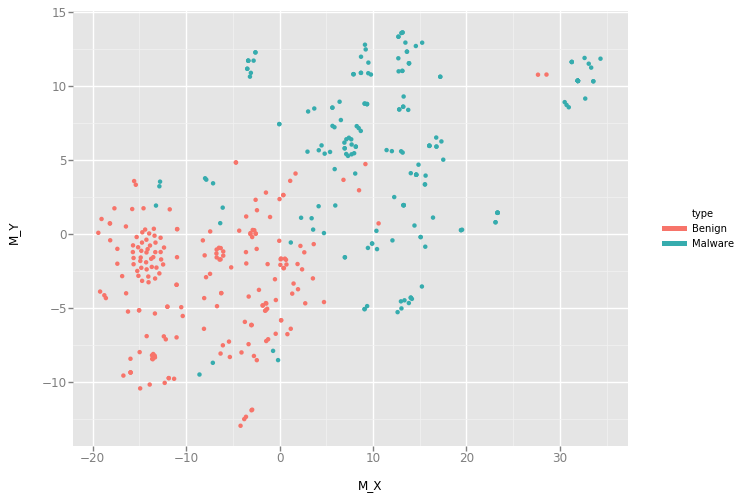

<ggplot: (-9223372036563915737)>

In [76]:
ggplot(final_mal,aes(x='M_X',y='M_Y',color = 'type')) + geom_point()

### 4. Interpretation for Malware and Non-Malware Applications Visualization using T-SNE

We can see that when projected on two components all the malware applications lie on the lower Y component spectrum and all the benign or non malware applications lie on the higher Y value of the spectrum and hence we can see clear clusters being formed more distinctly in the plt.scatter plot. Visually T-SNE helps clearly segregate the Malware and benign apps based on the X and Y components, this can be extended to implement a clustering algorithm to identify malware applications based on permissions being sought by the application